# Assignment 2: RNN, LSTM, Attention, and Transformer

**Author: Chang Chen (TA) and Sungjin Ahn (Instructor)**

In this assignment, we will implement neural machine translation (NMT) models using RNNs, LSTMs, attention mechanisms, and Transformes. The assignmenet contains five modules
1. Dataset preparation (Guide 1)
1. Baseline seq2seq RNN (Guide 2)
1. LSTM seq2seq (Task 1)
1. Seq2seq with Attention (Task 2)
1. Transformer (Task 3)

First two modules are for guidance and the last three modules are tasks for you to implement. 




In [1]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

## 1. Guide: Datasets

In this section, we provide the dataset preparation guidance. You do not need to implement any code in this section.

### 1.1 Data Download and Raw Text Preprocessing

We will use the English-to-French dataset. As shown below, the dataset contains multiple lines each of which has a English sentence and its Frence translation separated by a TAB. 

In [2]:
def download_if_not_exist(file_name):
  
  if not os.path.exists(file_name):
    import urllib.request
    DATA_URL = 'https://download.pytorch.org/tutorial/data.zip'

    file_name, _ = urllib.request.urlretrieve(DATA_URL, './data.zip')
    
  return file_name

def read_raw(file_name):
  file_name = download_if_not_exist(file_name)
  
  with zipfile.ZipFile(file_name, 'r') as fzip:
    raw_text = fzip.read(file_name.split('.')[-2][1:] + '/eng-fra.txt').decode('utf-8')
  return raw_text

In [3]:
raw_text = read_raw('./data.zip')
print(raw_text[:200])

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !
Wait!	Attends !
Wait!	Attendez !
I see.	Je comprends.


For raw text preprocessing, we need to replace special symbols with spaces and convert all characters into the lower cases.

In [4]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

We further split the source-target pairs into the source list and the target list.

In [5]:
def split_source_target(text, max_len):
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if i > 5000: # we only use 20000 pairs of translation
      break
    parts = line.split('\t')
    if len(parts) == 2:
      src_tokens = parts[0].split(' ')
      tgt_tokens = parts[1].split(' ')
      if (len(src_tokens) <= max_len) and (len(tgt_tokens) <= max_len):
        source.append(src_tokens)
        target.append(tgt_tokens)
  return source, target

In [6]:
def prepare_data(raw_text, max_len=10000):
  text = preprocess_raw(raw_text)
  source, target = split_source_target(text, max_len)
  return source, target

source, target = prepare_data(raw_text)

Using the whole dataset takes too much memory, and it is also hard to train with a large vocabulary. Thus, we will filter out some words by looking at the statistical properties of the dataset.

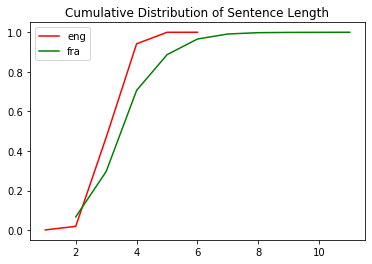

In [7]:
def len_dis(text):
  lens = [len(line) for line in text]
  len_counter = collections.Counter(lens)

  lens = np.array(list(len_counter.keys()))
  sort_idx = np.argsort(lens)
  lens_sort = lens[sort_idx]
  len_counts = np.array(list(len_counter.values()))
  len_counts_sort = len_counts[sort_idx]
  p = np.cumsum(len_counts_sort) / len_counts_sort.sum()
  return p, lens_sort
  
src_p, src_lens_sort = len_dis(source)
tgt_p, tgt_lens_sort = len_dis(target)
plt.plot(src_lens_sort, src_p, 'r-', label='eng')
plt.plot(tgt_lens_sort, tgt_p, 'g-', label='fra')
plt.title('Cumulative Distribution of Sentence Length')
plt.legend()
plt.show()

From the above plots, we can see that more than 90% of the sentences have a length of less than 8. Thus, we can filter out sentences of length greater than 8. We also filter out words that occur less than 5 times in the corpus.

In [8]:
# hyper-param
MAX_LEN = 8
MIN_FREQ = 5

### 1.2 Build Vocabulary

Each word needs a unique index, and the words that have been filtered out need a special token to represent them. The following class Vocab is used to build the vocabulary. Some basic helper functions or dictionaries are also provided:
- Dictionary word2index: Convert word string into index: 
- Dictionary index2word: Convert index into word string
- helper function _build_vocab(): Build dictionaries for converting from words to indices and vice versa
- Word Counter, num_word: Record the total number of unique tokens in the vocabulary 
    
There are 4 special tokens added in the vocabulary:
- 'pad': padding token. Sentences shorter than MAX_LEN is padded by this symbol to make the length to MAX_LEN
- 'bos': beginning of sentence. This indicates the beginning of a sentence
- 'eos': end of sentenct. This indicates the end of a sentence
- 'unk': unknown word. This represents words that have been filtered out (words that are not in the vocabulary)

In [9]:
class Vocab():
  def __init__(self, name, tokens, min_freq):
    self.name = name
    self.index2word = {
      0: 'pad',
      1: 'bos',
      2: 'eos',
      3: 'unk'
    }
    self.word2index = {v: k for k, v in self.index2word.items()}
    self.num_word = 4
    token_freq = collections.Counter(tokens)
    tokens = [token for token in tokens if token_freq[token] >= MIN_FREQ]
    self._build_vocab(tokens)
    
  def _build_vocab(self, tokens):
    for token in tokens:
      if token not in self.word2index:
        self.word2index[token] = self.num_word
        self.index2word[self.num_word] = token
        self.num_word += 1
        
  def __getitem__(self, tokens):
    if not isinstance(tokens, (list, tuple)):
      return self.word2index.get(tokens, self.word2index['unk'])
    else:
      return [self.__getitem__(token) for token in tokens]

### 1.3 Build Dataset

The dataset pipeline involves the following steps:
- For target language, every sentence will be 'sandwiched' with the 'bos' token and the 'eos' token.
- Every sentence that has a length less than MAX_LEN will be padded to the MAX_LEN with the *padding_token*.
- The dataset should return the converted tensor and the corresponding valid length before padding.
- We use the Pytorch *DataLoader* API to build the dataset generator.

In [10]:
def build_vocab(name, tokens, min_freq):
  tokens = [token for line in tokens for token in line]
  return Vocab(name, tokens, min_freq)

def build_vocabs(lang_src, lang_tgt, src_text, tgt_text):
  vocab_src = build_vocab(lang_src, src_text, MIN_FREQ)
  vocab_tgt = build_vocab(lang_tgt, tgt_text, MIN_FREQ)
  return vocab_src, vocab_tgt

def pad(line, padding_token):
  return line + [padding_token] * (MAX_LEN + 2 - len(line))

def build_tensor(text, lang, is_source):
  lines = [lang[line] for line in text]
  if not is_source:
    lines = [[lang['bos']] + line + [lang['eos']] for line in lines]
  array = torch.tensor([pad(line, lang['pad']) for line in lines])
  valid_len = (array != lang['pad']).sum(1)
  return array, valid_len

def load_data_nmt(batch_size=2):
  lang_eng, lang_fra = build_vocabs('eng', 'fra', source, target)
  src_array, src_valid_len = build_tensor(source, lang_eng, True)
  tgt_array, tgt_valid_len = build_tensor(target, lang_fra, False)
  train_data = torch.utils.data.TensorDataset(
    src_array, src_valid_len, tgt_array, tgt_valid_len)
  train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
  return lang_eng, lang_fra, train_iter


source, target = prepare_data(raw_text, max_len=MAX_LEN)
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size=2)
print('Vocabulary size of source language: {}'.format(vocab_eng.num_word))
print('Vocabulary size of target language: {}'.format(vocab_fra.num_word))
print('Total number of sentence pairs: {}'.format(len(source)))

Vocabulary size of source language: 433
Vocabulary size of target language: 420
Total number of sentence pairs: 4990


## 2. Guidance: Sequence to Sequence with RNN (baseline)

In this section, we provide the implementation of the seq2seq baseline model. You do not need to implement any code in this section. The following figure highlights the architecture of the seq2seq model. An encoder RNN encodes the input sequence into its hidden state, and passes the last hidden state to the decoder RNN. The decoder generates the target sequence.

Implementation Details:

- Embedding: We have represented each word with an integer or one-hot vector. We need an embedding layer to map an input word to its embedding vector.
- Encoder: A vanilla RNN is used to encode a source sequence. The final hidden state is returned as output and passed to the decoder RNN.
- Decoder: Another vanilla RNN is implemented to generate the target sequence. The hidden state is initialized with the last hidden state from the encoder.
- Encoder-Decoder: The class NMTRNN is built by combining the encoder and the decoder, and yields the loss and predictions.
- Loss: We have padded all sentences so that they have the same MAX_LEN. Thus, when we compute the loss, the loss from those padding_tokens should be masked out.

<div>
<img src="./img/seq2seq.svg" width="600"/>
</div>
Image source: https://github.com/dsgiitr/d2l-pytorch/blob/master/img/seq2seq.svg

In [11]:
class Encoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Encoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.hidden_size = hidden_size
    
  def forward(self, sources, valid_len):
    """
    Inputs:
      source: tensor of size (N, T), where N is the batch size, T is the length of the sequence(s)
      valid_len: tensor of size (N,), indicating the valid length of sequence(s) (the length before padding)
    """
    word_embedded = self.embedding(sources)
    N = word_embedded.shape[0]
    
    h = sources.new_zeros(1, N, self.hidden_size).float() # initialize hidden state with zeros
    
    o, h = self.enc(word_embedded, h)
    
    return o[np.arange(N), valid_len] # return the hidden state of the valid last time step

class Decoder(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size):
    super(Decoder, self).__init__()
    """
    inputs:
      vocab_size: int, the number of words in the vocabulary
      embedding_dim: int, dimension of the word embedding
      hidden_size: int, dimension of the hidden state of vanilla RNN
    """
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.enc = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.output_emb = nn.Linear(hidden_size, vocab_size)
    self.hidden_size = hidden_size
    
  def forward(self, h, target):
    word_embedded = self.embedding(target)
    N, T = word_embedded.shape[:2]
    
    o, h = self.enc(word_embedded, h.view(1,N,self.hidden_size))
    pred = self.output_emb(o)
    return pred, h

class NMTRNN(nn.Module):
  def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size):
    super(NMTRNN, self).__init__()
    self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size)
    self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size)
    
  def forward(self, src, src_len, tgt, tgt_len):
    h = self.enc(src, src_len)
    T = tgt.shape[1]
    
    if self.training:
      pred, _ = self.dec(h, tgt)
      loss = 0
      for t in range(T-1):
        # target sequence should shift by one time-step, because we are predicting the next word
        loss = loss + F.nll_loss(F.log_softmax(pred[:, t]), tgt[:, t+1], ignore_index=0)

      return loss, pred.argmax(dim=-1)
    else:
      """
      When predicting a sequence given the 'bos' token, the input for the next step is the predicted
      token from the previous time step.
      """
      inputs = tgt[:, :1]
      preds = []
      for t in range(MAX_LEN+1): # plus the 'eos' token
        pred, h = self.dec(h, inputs)
        preds.append(pred)
        inputs = pred.argmax(dim=-1)
        
      pred = torch.cat(preds, dim=1).argmax(dim=-1)
      return pred
        

In [12]:
# training 
batch_size = 32
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

embedding_dim = 250
hidden_size = 128

lr = 1e-3
epoch = 50

net = NMTRNN(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size)
device = torch.device('cuda:0') # cuda:0 if you have gpu
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_list = []
print_interval = len(train_iter)
total_iter = epoch * len(train_iter)
for e in range(epoch):
  net.train()
  for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]
    
    loss, pred = net(*train_data)
    
    loss_list.append(loss.mean().detach())
    optimizer.zero_grad()
    loss.mean().backward()
    optimizer.step()
    
    step = i + e * len(train_iter)
    if step % print_interval == 0:
      print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
      print('pred:\t {}\n'.format(pred[0].detach().to(device)))
      print('tgt:\t {}\n'.format(train_data[2][0][1:].to(device)))

/home/lin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iter 0 / 7800	Loss:	49.313881
pred:	 tensor([172, 101, 387, 189, 347, 315, 178, 277, 277, 126], device='cuda:0')

tgt:	 tensor([14, 28,  3, 11,  2,  0,  0,  0,  0], device='cuda:0')

iter 156 / 7800	Loss:	11.846785
pred:	 tensor([14,  3, 11,  2, 11, 11, 11, 11, 11, 11], device='cuda:0')

tgt:	 tensor([36,  3, 11,  2,  0,  0,  0,  0,  0], device='cuda:0')

iter 312 / 7800	Loss:	13.001339
pred:	 tensor([ 3,  5, 11,  2, 11,  3, 11, 11, 11, 11], device='cuda:0')

tgt:	 tensor([ 3, 52, 11,  2,  0,  0,  0,  0,  0], device='cuda:0')

iter 468 / 7800	Loss:	9.053352
pred:	 tensor([14, 28,  3, 11,  2, 11,  3, 11, 11, 11], device='cuda:0')

tgt:	 tensor([ 14, 201, 309,  11,   2,   0,   0,   0,   0], device='cuda:0')

iter 624 / 7800	Loss:	9.884995
pred:	 tensor([ 14,  40, 202,   3,  11,   3,  11,   2,  11,   3], device='cuda:0')

tgt:	 tensor([ 38, 116, 202,   3, 207,   3,  11,   2,   0], device='cuda:0')

iter 780 / 7800	Loss:	7.563014
pred:	 tensor([ 3,  3, 24,  2,  5,  3,  5,  5,  5,  5], devi

**Loss Curve**

Plot and save the loss curve for the report.

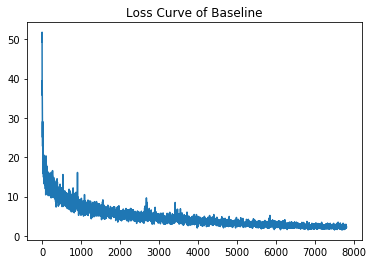

In [13]:
# save the loss curve figure in a file for the report
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Curve of Baseline')
plt.savefig('./report_fig/loss_curve_baseline.png')

**Prediction Accuracy**

Print out 5 prediction samples, and calculate the prediction accuracy over the training dataset.

In [14]:
def comp_acc(pred, gt, valid_len, device):
  N, T_gt = gt.shape[:2]
  _, T_pr = pred.shape[:2]
  assert T_gt == T_pr, 'Prediction and target should have the same length.'
  len_mask = torch.arange(T_gt).expand(N, T_gt).to(device)
  len_mask = (len_mask < valid_len[:, None])
  
  pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
  pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
  return pred_acc
  
net.eval()# for predicting, we need turn off the net.training by calling eval()
acc_list = []
for i, train_data in enumerate(train_iter):
  train_data = [ds.to(device) for ds in train_data]
  pred = net(*train_data)
  pred_acc = comp_acc(pred.detach().to(device), train_data[2].detach().to(device)[:, 1:], train_data[3].to(device), device)
  acc_list.append(pred_acc)
  if i < 5:# print 5 samples from 5 batches
    pred = pred[0].detach().to(device)
    pred_seq = []
    for t in range(MAX_LEN+1):
      pred_wd = vocab_fra.index2word[pred[t].item()] 
      if pred_wd != 'eos':
        pred_seq.append(pred_wd)

    print('pred:\t {}\n'.format(pred_seq))
    print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].to(device)]))
    
print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))

pred:	 ['fais', 'un', 'unk', '!', '.', '.']

tgt:	 ['faites', 'un', 'unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['merci', 'bien', '.', '.', '.', '.']

tgt:	 ['unk', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['je', 'me', 'unk', 'à', 'toi', '.', '.']

tgt:	 ['je', 'me', 'déteste', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['nous', 'unk', '.', '.', '.', '.']

tgt:	 ['nous', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

pred:	 ['ce', 'sont', 'des', 'unk', '.', '.', '.']

tgt:	 ['ils', 'sont', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

Prediction Acc.: 0.7132


## 3. TASK: Sequence to Sequence with LSTM and Attention

In this task, you will improve the baseline model by implementing LSTM and the attention mechanism. The following skeleton codes will walk you through the required implementations.

### 3.1 TASK: LSTM Implementation

LSTM eliminates the gradient explosion/vanishing problem. Its state and gate update at each time step can be summarized as follows:

$$
\begin{align*}
&\text{State Update} &&& C_t &= F_t \odot C_{t-1} + I_t \odot \tilde{C}_t \\
&\text{Hidden States} &&& H_t &= O_t \odot \text{tanh}(C_t) \\
&\text{Proposal} &&& \tilde{C}_t &= \text{tanh}( X_tW_{xc} + H_{t-1}W_{hc} + b_c ) \\
&\text{Input Gate} &&& I_t &= \sigma( X_tW_{xi} + H_{t-1}W_{hi} + b_i ) \\
&\text{Forget Gate} &&& F_t &= \sigma( X_tW_{xf} + H_{t-1}W_{hf} + b_f ) \\
&\text{Output Gate} &&& O_t &= \sigma( X_tW_{xo} + H_{t-1}W_{ho} + b_o ) \\
\end{align*}
$$
    
**To-dos**
- Implement the LSTM class:
    - (5 points) Complete the initialization function *init_params()*. Refer to homework 1 for initialization script. Also feel free to try different initialization methods in *torch.nn.init*
    - (10 points) Complete the function *lstm()* which performs the feed-forward pass of LSTM

In [24]:
from enum import IntEnum
class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, device):
        super(LSTM, self).__init__()
        self.device = device
        self.params = self.init_params(input_size, hidden_size, device)
        self.hidden_size = hidden_size
        """
        Inputs:
          input_size: int, feature dimension of input sequence
          hidden_size: int, feature dimension of hidden state
          device: torch.device()
        """
  
    def init_params(self, input_size, hidden_size, device):
        """
        Inputs:
          input_size: int, feature dimension of input sequence
          hidden_size: int, feature dimension of hidden state

        Outputs:
          Weights for proposal: W_xc, W_hc, b_c
          Weights for input gate: W_xi, W_hi, b_i
          Weights for forget gate: W_xf, W_hf, b_f
          Weights for output gate: W_xo, W_ho, b_o
        """

        ###  START OF YOUR CODE ###
        def normal(shape):
            return nn.Parameter(torch.randn(shape, dtype=torch.float32, device=device)*0.01, requires_grad=True)
        def three_rand_params():
            return(normal([input_size, hidden_size]),
                   normal([hidden_size, hidden_size]),
                   nn.Parameter(torch.zeros([hidden_size], dtype=torch.float32, device=device), requires_grad=True))
        W_xc, W_hc, b_c = three_rand_params()
        W_xi, W_hi, b_i = three_rand_params()
        W_xf, W_hf, b_f = three_rand_params()
        W_xo, W_ho, b_o = three_rand_params()
        ###  END OF YOUR CODE ###

        params = [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o]
        return params
    
    def lstm(self, X, state):
        """
        Inputs:
          X: tuple of tensors (src, src_len). src, size (N, D_in) or (N, T, D_in), where N is the batch size,
            T is the length of the sequence(s). src_len, size of (N,), is the valid length for each sequence.

          state: tuple of tensors (h, c). h, size of (N, hidden_size) is the hidden state of LSTM. c, size of 
                (N, hidden_size), is the memory cell of the LSTM.

        Outputs:
          o: tensor of size (N, T, hidden_size).
          state: the same as input state.
        """

        ###  START OF YOUR CODE ###
        device = self.device
        [W_xc, W_hc, b_c, W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o] = self.params
        H,C = state

        X.to(device)
        hidden_seq = []
        bs, seq_sz, _ = X.size()
        for t in range(seq_sz):
            x_t = X[:, t, :]
            I = torch.sigmoid( x_t@W_xi + torch.mm(H, W_hi) + b_i).to(device)
            Fog = torch.sigmoid( torch.mm(x_t, W_xf) + torch.mm(H, W_hf) + b_f)
            O = torch.sigmoid( torch.mm(x_t, W_xo) + torch.mm(H, W_ho) + b_o)
            C_tilda = torch.tanh( torch.mm(x_t, W_xc) + torch.mm(H, W_hc) + b_c)
            C = Fog*C + I*C_tilda
            H = O*torch.tanh(C)
            hidden_seq.append(H.unsqueeze(Dim.batch))
        hidden_seq = torch.cat(hidden_seq, dim = Dim.batch)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        ###  END OF YOUR CODE ###

        state = (H, C)
        return hidden_seq, state
  
    def forward(self, inputs, state):
        return self.lstm( inputs, state)

### 3.2 TASK: Attention Mechanism

Another improvement would be the Attention Mechanism. An example illustrating why applying attention mechanisms can improve the performance is shown in the picture below. An English sentence and its Chinese is visualized and aligned into blue boxes and red boxes, respectively. It can be seen that the Chinese character '她' has a long distance from its English counterpart, 'she'. Since only the final hidden state is passed to the decoder, it's hard for the baseline model to 'attend' to information a long time ago.

<div>
<img src="./img/encoder-decoder-example.png" width="600"/>
</div>
Image source: https://lilianweng.github.io/lil-log/assets/images/encoder-decoder-example.png

- **Attention**

    Given a query, $\mathbf{q}$, and a set of (key, value) pairs, $\{ \mathbf{k}_i, \mathbf{v}_i\}^N$, the attention mechanism computes a weighted sum of values based on the normalized score obtained from the query and each key:
    $$
    \begin{align*}
    \mathbf{a} &= \alpha(\mathbf{q}, \mathbf{K})\text{, where } \mathbf{K} = \{\mathbf{k}_i\}^N \\
    \mathbf{b} &= \text{softmax}(\mathbf{a}) \\
    \mathbf{o} &= \mathbf{b} \cdot \mathbf{V}\text{, where } \mathbf{V} = \{\mathbf{v}_i\}^N
    \end{align*}
    $$
    The $\alpha()$, which maps two vectors into a scalar, is the score function that can be chosen from a wide range, e.g. the cosine function, dot-product function, scaled dot-product funtion and etc.
    
- **Using Attention in seq2seq Models**

    Given the whole sequence of hidden states, $\{h_j\}^{T_x}$, the decoder summarizes an averaged context vector, $c_i$, to update its current hidden state, $s_i$. Here, a() is the score function. $y_i$ is the target, $T_x$ denotes the valid length of the sequence. Formally, this process is computed as follows. Details can be found in the [paper](https://arxiv.org/pdf/1409.0473.pdf).
    
    \begin{align*}
    e_{ij} &= a(s_{i-1}, h_j), j \in \{1, \cdots, T_x\} \\
    \mathbf{\alpha}_i &= \text{softmax}(\mathbf{e}_{i}) \\
    c_i &= \sum^{T_x}_{j=1} \alpha_{ij}h_j \\
    s_i &= f(s_{i-1}, y_{i-1}, c_i)
    \end{align*}
    
    
    
- **Scaled Dot Product Attention**
    - The scaled dot-product attention uses the score function as: $\alpha(\mathbf{q}, \mathbf{k}) = \mathbf{q} \mathbf{k}^T / \sqrt{d}$, where $d$ is the dimension of query (also keys). The following figures visualizes this process in matrix form, in which $Q \in \mathcal{R}^{m\times d_k}, \mathbf{K} \in \mathcal{R}^{n \times d_k}$, and $\mathbf{V} \in \mathcal{R}^{n \times d_v}$. A visualization of the attention calculation in matrix form of is shown below:

    <div>
    <img src="./img/self-attention-matrix-calculation-2.png" width="600"/>
    </div>
Image source: http://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png
    
**To-do**:
- (5 points) Implement the masked_softmax() function.
- (5 points) Implement the scaled dot-product attention in matrix multiplication, no **for loop** is allowed.

In [25]:
def masked_softmax(X, valid_length, device):
    """
    inputs:
    X: tensor of size (N, n, m) or (N, m)
    valid_length: tensor of (N,)
    """
    ###  START OF YOUR CODE ###
    X.to(device)
    valid_length.to(device)
    softmax = nn.Softmax(2)
    if valid_length is None:
        return softmax(X)
    else:
        shape = X.shape
        maxlen = shape[-1]
        if X.ndim == 2:
            valid_length = valid_length.unsqueeze(-1).expand_as(X).to(device)
            idx = torch.arange(maxlen).unsqueeze(0).expand_as(X).to(device)
        else:
            if valid_length.ndim==1:
                valid_length = valid_length.unsqueeze(-1).unsqueeze(-1).expand_as(X).to(device)
            else:
                valid_length = valid_length.unsqueeze(-1).expand_as(X).to(device)
            idx = torch.arange(maxlen).unsqueeze(0).unsqueeze(1).expand_as(X).to(device)
        mask = idx < valid_length
    ###  END OF YOUR CODE ###
    X[~mask] = -(1e7)
    Y = softmax(X)
    return Y

In [26]:
class DotProductAttention(nn.Module): 
    def __init__(self, device):
        super(DotProductAttention, self).__init__()
        self.device = device
    def forward(self, query, key, value, valid_length=None):
        """
        inputs:
          query: tensor of size (B, n, d)
          key: tensor of size (B, m, d)
          value: tensor of size (B, m, dim_v)
          valid_length: either (B, )

          B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
          d is the feature dimension of the query, and dim_v is the feature dimension of the value.

        Outputs:
          attention: tensor of size (B, n, dim_v), weighted sum of values
        """
        ###  START OF YOUR CODE ###
        device = self.device
        query.to(device)
        key.to(device)
        value.to(device)
        d = float(query.shape[-1])
        scores = (torch.bmm(query, key.transpose(-2,-1)))/(d**0.5)
        attention_weights = masked_softmax(scores, valid_length, device)
        attention = torch.bmm(attention_weights, value)
        ###  END OF YOUR CODE ###

        return attention

### Correctness Check for DotProductAttention

You can copy and run the following snippet to check the whether your implementation of DotProductAttention is correct or not.

```python
att = DotProductAttention()
keys = torch.zeros((2,10,2),dtype=torch.float)
values = torch.arange((40), dtype=torch.float).view(1,10,4).repeat(2,1,1)
atten(torch.zeros((2,1,2),dtype=torch.float), keys, values, torch.FloatTensor([2, 6]))


Outputs:
tensor([[[11.8604, 12.8604, 13.8604, 14.8604]],

        [[12.7894, 13.7894, 14.7894, 15.7894]]])
```

- **MLP Attention**

    The MLP attention mechanism, where the score function is computed as: $ \alpha(\mathbf{q}, \mathbf{k}) = \mathbf{v}^T\text{tanh}(W_k\mathbf{k} + W_q\mathbf{q})$, where $\mathbf{v}, \mathbf{W_q}\text{, and }\mathbf{v}$ are learnable parameters.
    
**To_do**:
    - (5 points) Implement the MLP attention in matrix form, no **for loop** is allowed.

In [27]:
class MLPAttention(nn.Module):  
    def __init__(self, d_v, d_k, d_q, device):
        super(MLPAttention, self).__init__()
        """
        Inputs:
          d_k: feature dimension of key
          d_v: feature dimension of vector v
          d_q: feature dimension of query
        """
        ###  START OF YOUR CODE ###
        self.W_k = nn.Parameter(torch.randn([d_v, d_k], dtype=torch.float32, device=device)*0.1, requires_grad=True)
        self.W_q = nn.Parameter(torch.randn([d_v, d_q], dtype=torch.float32, device=device)*0.1, requires_grad=True)
        self.v = nn.Parameter(torch.randn([1, d_v], dtype=torch.float32, device=device)*0.1, requires_grad=True)
        ###  END OF YOUR CODE ###

    def forward(self, query, key, value, valid_length):
        """
        inputs:
          query: tensor of size (B, n, d)
          key: tensor of size (B, m, d)
          value: tensor of size (B, m, dim_v)
          valid_length: either (B, )
          n: d_q
          m: d_k
          d: d_v
          B is the batch_size, n is the number of queries, m is the number of <key, value> pairs,
          d is the feature dimension of the query, and dim_v is the feature dimension of the value.

        Outputs:
          attention: tensor of size (B, n, dim_v), weighted sum of values
        """
        ###  START OF YOUR CODE ###
        key = torch.matmul(key, self.W_k.t()).unsqueeze(0)
        query = torch.matmul(query.to(device), self.W_q.t().unsqueeze(0))
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = torch.matmul(features, self.v.t()).squeeze(-1).squeeze(0)
        attention_weights = masked_softmax(scores, valid_length, device)
        Y = torch.bmm(attention_weights, value.to(device))
        ###  END OF YOUR CODE ###

        return Y

In [28]:
class MLPAttention(nn.Module):  
    def __init__(self, units, dropout, **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        # Use flatten=True to keep query's and key's 3-D shapes.
        self.W_k = nn.Linear(2, units, bias=False)
        self.W_q = nn.Linear(2, units, bias=False)
        self.v = nn.Linear(8, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_length):
        query, key = self.W_q(query), self.W_k(key)
        # expand query to (batch_size, #querys, 1, units), and key to
        # (batch_size, 1, #kv_pairs, units). Then plus them with broadcast.
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(-1) 
        attention_weights = self.dropout(masked_softmax(scores, valid_length))
        return torch.bmm(attention_weights, value)

### 3.3 TASK: Encoder-Decoder


Build a seq2seq model with LSTM and attention:
- (5 points) Complete the Encoder forward() function.
- (10 points) Complete the Decoder forward() function.
- (10 points) Complete the class NMTLSTM. If you could not implement the class LSTM, you can use torch.nn.LSTM to help you finish this task.
- Implement the training script.
    

In [29]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, device):
        super(Encoder, self).__init__()
        """
        inputs:
          vocab_size: int, the number of words in the vocabulary
          embedding_dim: int, dimension of the word embedding
          hidden_size: int, dimension of vallina RNN
        """
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = LSTM(embedding_dim, hidden_size, device)
        self.output_emb = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        
    def forward(self, sources, valid_len):
        ###  START OF YOUR CODE ###
        word_embedded = self.embedding(sources)
        N = word_embedded.shape[0]
        h = sources.new_zeros(N, self.hidden_size).float().to(device)
        c = sources.new_zeros(N, self.hidden_size).float().to(device)
        state = (h,c)
        out, state = self.rnn(word_embedded, state)
        ###  END OF YOUR CODE ###

        return out, state

In [30]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, device):
        super(Decoder, self).__init__()
        """
        inputs:
          vocab_size: int, the number of words in the vocabulary
          embedding_dim: int, dimension of the word embedding
          hidden_size: int, dimension of vallina RNN
        """
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = LSTM(embedding_dim+hidden_size, hidden_size, device)
        self.att = DotProductAttention(device)
        self.output_emb = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.device = device

    def forward(self, state, target, valid_len):
        ###  START OF YOUR CODE ###
        word_embedded = self.embedding(target)
        outputs = []
        e_h, e_c = state
        k_v = e_h.unsqueeze(1)
        bs, seq_sz, _ = word_embedded.size()
        for t in range(seq_sz):
            x_t = word_embedded[:, t, :]
            h, c = state
            query = h.unsqueeze(1)
            context = self.att(query, k_v, k_v, valid_len)
            # Concatenate on the feature dimension
            x_t = torch.cat((context, x_t.unsqueeze(1)), dim=-1)
            out, state = self.rnn( x_t, state)
            outputs.append(out)
        pred = self.output_emb(torch.cat(outputs, dim=1))
        ###  END OF YOUR CODE ###
        return pred, state

In [31]:
class NMTLSTM(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, device):
        super(NMTLSTM, self).__init__()
        self.enc = Encoder(src_vocab_size, embedding_dim, hidden_size, device)
        self.dec = Decoder(tgt_vocab_size, embedding_dim, hidden_size, device)

    def forward(self, src, src_len, tgt, tgt_len):
        output, h = self.enc(src, src_len)
        T = tgt.shape[1]

        if self.training:
            pred, _ = self.dec(h, tgt, tgt_len)
            loss = 0
            for t in range(T-1):
                # target sequence should shift by one time-step, because we are predicting the next word
                loss = loss + F.nll_loss(F.log_softmax(pred[:, t]), tgt[:, t+1], ignore_index=0)
                

            return loss, pred.argmax(dim=-1)

        else:
            """
            When predicting a sequence given the 'bos' token, the input for the next step is the predicted
            token from the previous time step.
            """
            inputs = tgt[:, :1]
            preds = []
            for t in range(MAX_LEN+1): # plus the 'eos' token
                pred, h = self.dec(h, inputs, tgt_len)
                inputs = pred.argmax(dim=-1)
                preds.append(pred)
            pred = torch.cat(preds, dim=1).argmax(dim=-1)
            return pred


In [38]:
# # training 
batch_size = 32+32
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)

embedding_dim = 250
hidden_size = 128+32

lr = (1e-2)*5
epoch = 50+50
device = torch.device('cuda:0') # cuda:0 if you have gpu
net = NMTLSTM(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, device)
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_list = []
print_interval = len(train_iter)*10
total_iter = epoch * len(train_iter)
for e in range(epoch):
    net.train()
    for i, train_data in enumerate(train_iter):
        train_data = [ds.to(device) for ds in train_data]

        loss, pred = net(*train_data)

        loss_list.append(loss.mean().detach())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()

        step = i + e * len(train_iter)
        if step % print_interval == 0:
            print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
            print('pred:\t {}\n'.format(pred[0].detach().to(device)))
            print('tgt:\t {}\n'.format(train_data[2][0][1:].to(device)))


/home/lin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


iter 0 / 7800	Loss:	48.306084
pred:	 tensor([ 32, 246, 219, 209, 214, 246, 303, 219, 219, 219], device='cuda:0')

tgt:	 tensor([ 38, 116, 202,   3,  11,   2,   0,   0,   0], device='cuda:0')

iter 780 / 7800	Loss:	3.606470
pred:	 tensor([14,  3, 11,  2,  2, 11, 11, 11, 11, 11], device='cuda:0')

tgt:	 tensor([14,  3, 11,  2,  0,  0,  0,  0,  0], device='cuda:0')

iter 1560 / 7800	Loss:	2.896785
pred:	 tensor([ 14, 116, 179,   3,  37,   3,  11,   2,   2,  11], device='cuda:0')

tgt:	 tensor([ 14, 116, 179, 369,  37,   3,  11,   2,   0], device='cuda:0')

iter 2340 / 7800	Loss:	2.102764
pred:	 tensor([ 38, 357,   3, 409,  11,   2,   2,  11,  11,  11], device='cuda:0')

tgt:	 tensor([ 38, 169, 113, 409,  11,   2,   0,   0,   0], device='cuda:0')

iter 3120 / 7800	Loss:	2.021135
pred:	 tensor([ 52, 388,   3,  24,   2,   2,   3,  11,  11,  11], device='cuda:0')

tgt:	 tensor([ 52, 388,   3,  24,   2,   0,   0,   0,   0], device='cuda:0')

iter 3900 / 7800	Loss:	1.602879
pred:	 tensor([141, 

### Results Report

- (5 points) Generate predictions with NMTLSTM. During predicting, the decoder only sees the 'bos' token and hidden states from encoder.
- (5 points) Plot the loss curve, report the prediction accuracy and print out several (~5) prediction samples together with corresponding targets. Bonus points will be assigned depending on the prediction accuracy.

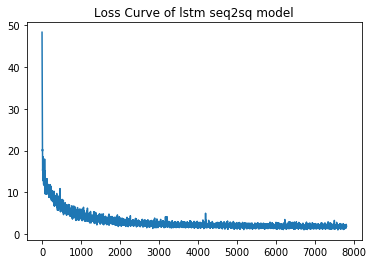

In [39]:
# save the loss curve figure in a file for the report
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Curve of lstm seq2sq model')
plt.savefig('./report_fig/loss_curve_lstm.png')

In [40]:
# Prediction Accuracy
# Print out 5 prediction samples, and calculate the prediction accuracy over the training dataset.
def comp_acc(pred, gt, valid_len, device):
    N, T_gt = gt.shape[:2]
    _, T_pr = pred.shape[:2]
    assert T_gt == T_pr, 'Prediction and target should have the same length.'
    len_mask = torch.arange(T_gt).expand(N, T_gt).to(device)
    len_mask = (len_mask < valid_len[:, None])

    pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
    pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
    return pred_acc
  
net.eval()# for predicting, we need turn off the net.training by calling eval()
acc_list = []
for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]
    pred = net(*train_data)
    pred_acc = comp_acc(pred.detach().to(device), train_data[2].detach().to(device)[:, 1:], train_data[3].to(device), device)
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
        pred = pred[0].detach().to(device)
        pred_seq = []
        for t in range(MAX_LEN+1):
            pred_wd = vocab_fra.index2word[pred[t].item()] 
            if pred_wd != 'eos':
                pred_seq.append(pred_wd)

        print('pred:\t {}\n'.format(pred_seq))
        print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].to(device)]))
    
print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))

pred:	 ["c'est", 'bien', 'pour', 'vous', '.', 'unk', '.']

tgt:	 ["c'est", 'bien', 'pour', 'vous', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['unk', 'mon', 'unk', '!', 'unk', '.']

tgt:	 ['unk', 'mon', 'unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['venez', 'chez', 'moi', '!', 'unk', '.']

tgt:	 ['viens', 'chez', 'nous', '!', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['prends', 'un', 'unk', '.', 'unk', '.']

tgt:	 ['prenez', 'un', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['soyez', 'calme', '!', 'unk', '.']

tgt:	 ['soyez', 'unk', '!', 'eos', 'pad', 'pad', 'pad', 'pad', 'pad']

Prediction Acc.: 0.7575


## 4. TASK: Transformer

Recurrent Neural Networks can capture the long-range, variable-length sequential information, but updating the current state relies on the previous states. Thus it suffers from the inability of parallelization within the sequence. In contrast, CNNs are easy to parallelize while they cannot capture sequential dependency within variable-length sequences. Transformer resolves this dilemma.

### 4.1 Transformer Components Implementation

The following codes will walk you through each of them. The original paper can be found [here](https://arxiv.org/pdf/1706.03762.pdf).

**Multi-Head Self-Attention**


Note that each head in the multi-head self-attention is the scaled dot-product attention which you have already implemented in Section 3.2. To be specific, the steps in the multi-head attention can be summarzied by the following steps:

   1. The multi-head self-attention takes the initinal query $Q$, key $K$, and value $V$ as input. Note that, if not provided specifically, usually these are set to the same input embeddings $X=Q=K=V$ initially.
   
   1. Then, a linear projection is applied to $Q,K,V$ sepearately for each head $i=1,\dots,h$. 
      $$
   Q_i = QW^{Q}_i, K_i = KW^{K}_i, V_i = VW^{V}_i, i \in [0, \dots, h-1],
   $$
   
   where $W^Q_i \in \mathcal{R}^{d_{model} \times d_k}, W^K_i \in \mathcal{R}^{d_{model} \times d_k}\text{, and } W^V_i \in \mathcal{R}^{d_{model} \times d_v}$
     
   1. Apply the scaled dot-product attention to each of these projected set of queries, keys and values:
   $$
   \text{head}_i = \text{Attention}(Q_i, K_i, V_i) = \text{softmax}(\frac{Q_iK^T_i}{\sqrt{d_k}})V_i
   $$
   
   1. Concatenate all the heads together and project it with another learned linear projections: 
   
   $$
   \text{O} = \text{Concate(head}_1, \dots, \text{head}_h) \\
   \text{MultiHead}(Q, K, V) = \text{O}W^o, \hspace{10mm} \text{where } W^o \in \mathcal{R}^{{hd_v} \times d_{model}}
   $$

A good visualization from this blog is shown below. Transformer stacks several multi-head attention modules together, thus the first multi-head layer has input from the dataset, an additional embedding layer is needed to project the input sequence into appropriate dimensions. Otherwise, the output from the layer right below is directly used as input.

<div>
    <img src="./img/transformer_multi-headed_self-attention-recap.png" width="600"/>
</div>

Image source: http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png

**To-dos**:
- Complete the class MultiHeadAttention:
 - (5 points) Complete the __inti__() function, where the linear mappings for query, key, and values should be created.
 - (5 points) Complemte the forward() function, where the multi-head attention is performed. Note that, for the decoder in the Transformer, when applying self-attention, the sequential queries **cannot** attend to those at later time steps. For example, in a sequence, query entry at time step 5 can only observe the first 5 entries. You need to use masked softmax.

In [67]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, d_k, num_heads, device, **kwargs):
        super(MultiHeadAttention, self).__init__()
        """
        Inputs:
          d_model: int, the same d_model in paper, feature dimension of query/key/values
          d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
          num_heads: int, number of heads used for this MultiHeadAttention
        """
        self.num_heads = num_heads
        self.attn = DotProductAttention(device)
        self.d_model = d_model
        self.device = device
        ###  START OF YOUR CODE ###
        self.W_k = nn.Parameter(torch.randn([d_k, d_model], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_k = nn.Parameter(torch.zeros([d_model], dtype=torch.float32, device=device), requires_grad=False)
        self.W_q = nn.Parameter(torch.randn([d_k, d_model], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_q = nn.Parameter(torch.zeros([d_model], dtype=torch.float32, device=device), requires_grad=False)
        self.W_v = nn.Parameter(torch.randn([d_k, d_model], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_v = nn.Parameter(torch.zeros([d_model], dtype=torch.float32, device=device), requires_grad=False)
        self.W_o = nn.Parameter(torch.randn([d_model, d_model], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_o = nn.Parameter(torch.zeros([d_model], dtype=torch.float32, device=device), requires_grad=False)
        ###  END OF YOUR CODE ###


    def forward(self, query, key, value, valid_length):
        """
        inputs:
          query: tensor of size (B, T, d_q)
          key: tensor of size (B, m, d_k)
          value: tensor of size (B, m, d_v)
          valid_length: either (B, )

          B is the batch_size, T is length of sequence, d_q, d_k, and d_v are the feature dimensions of query,
          key, and value. In the paper, d_q = d_k = d_v.

        Outputs:
          attention
          """
        ###  START OF YOUR CODE ###
        query.to(device)
        key.to(device)
        value.to(device)
        if valid_length is not None:
            valid_length.to(device)
        bs = query.size(0)
        def transpose_qkv(X, num_heads):
            # Original X shape: (batch_size, seq_len, hidden_size * num_heads),
            # -1 means inferring its value, after first reshape, X shape:
            # (batch_size, seq_len, num_heads, hidden_size)
            X = X.contiguous().reshape(X.shape[0], X.shape[1], num_heads, -1)
            # After transpose, X shape: (batch_size, num_heads, seq_len, hidden_size)
            X = X.transpose(2, 1)
            # Merge the first two dimensions. Use reverse=True to infer shape from
            # right to left.
            # output shape: (batch_size * num_heads, seq_len, hidden_size)
            output = X.contiguous().reshape(-1, X.shape[2], X.shape[3])
            return output         
        #perform linear operation and split into h heads
        k = transpose_qkv(torch.matmul(key, self.W_k)+self.b_k, self.num_heads)
        q = transpose_qkv(torch.matmul(query, self.W_q)+self.b_q, self.num_heads)
        v = transpose_qkv(torch.matmul(value, self.W_v)+self.b_v, self.num_heads)
        if valid_length is not None:
            if valid_length.ndim == 1:
                valid_length = valid_length.repeat(self.num_heads)
            else:
                valid_length = valid_length.repeat((self.num_heads, 1))
        # calculate attention using function we will define next
        scores = self.attn(q, k, v, valid_length)
        scores = scores.contiguous().reshape(bs, self.num_heads, scores.shape[1], scores.shape[2])
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().reshape(bs, -1, self.d_model)
        attention = torch.matmul(concat, self.W_o)+self.b_o
        ###  END OF YOUR CODE ###


        return attention

### Position-wise Feed-Forward Network

Another key component in the Transformer block is called position-wise feed-forward network (FFN). It's called position-wise FFN because the linear mapping is applied to each position separately and identically. For example, for an embedded input of size $N \times T \times D_{in}$, there are $N*T$ vectors of dimension $D_{in}$. If we apply one layer position-wise FFN with weights of size $D_{in} \times D_{out}$. The linear projection will be applied to each of the $N*T$ vectors separately and identically. Thus, the output would have size $N \times T \times D_{out}$. 

Transformer stacks two layers of position-wsie FFN together, with a ReLU activation in between:

$$
\text{PositionWiseFFN}(x) = \text{max}(0, xW_1 + b_1)W_2 + b_2
$$

**To-dos**:

    - Complete the class PositionWiseFFN:
        - (5 points) Complete the __init__() function, where two position-wise FFN should be created.
        - (5 points) Complete the forward() function.

In [68]:
class PositionWiseFFN(nn.Module):
    def __init__(self, input_size, ffn_l1_size, ffn_l2_size, device):
        super(PositionWiseFFN, self).__init__()
        """
        Inputs:
          input_size: int, feature dimension of the input
          fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
          fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
        """
        self.W_1 = nn.Parameter(torch.randn([input_size, ffn_l1_size], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_1 = nn.Parameter(torch.zeros([ffn_l1_size], dtype=torch.float32, device=device), requires_grad=True)
        self.W_2 = nn.Parameter(torch.randn([ffn_l1_size, ffn_l2_size], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_2 = nn.Parameter(torch.zeros([ffn_l2_size], dtype=torch.float32, device=device), requires_grad=True)
        self.device = device
    def forward(self, X):
        """
        Input:
          X: tensor of size (N, T, D_in)
        Output:
          o: tensor of size (N, T, D_out)
        """
        ###  START OF YOUR CODE ###
        X.to(self.device)
        result = F.relu((torch.matmul(X, self.W_1)+self.b_1))
#         result[result<=0.0] = 0.0
        result = torch.matmul(result.to(self.device), self.W_2)+self.b_2
        ###  END OF YOUR CODE ###
        return result    

### Positional Encoding

Replacing RNNs with the multi-head attention layer and applying the position-wise feed-forward network makes the computation sofar parallelizable since these modules compute the output of each item in the sequence independently. But, to understand the meaning of a sequence, the sequential information is very important. To this end, Transformer model proposes the positional encoding:

$$
\begin{align*}
PE_{(pos, 2i)} &= sin(pos / 10000^{2i/d_{model}}) \\
PE_{(pos, 2i+1)} &= cos(pos / 10000^{2i/d_{model}}) 
\end{align*}
$$

An example borrowed from this [blog](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) can give an ituition how this positional encoding works. Suppose you want to encode the number from $0$ to $8$ using binary encoding, the result would like this:
$$
\begin{align*}
0: && 0  0  0 \\
1: && 0  0  1 \\
2: && 0  1  0 \\
3: && 0  1  1 \\
4: && 1  0  0 \\
5: && 1  0  1 \\
6: && 1  1  0 \\
7: && 1  1  1 \\
\end{align*}
$$
Note the frequency of ones in each digit is different. Thus, words at different locations will have different embedding features (digits in the example). The figure below visualized a position encoding matrix of dimension $\mathcal{R}^{50 \times 128}$

<div>
    <img src="./img/positional_encoding.png" width="600"/>
</div>

Image source: https://d33wubrfki0l68.cloudfront.net/ef81ee3018af6ab6f23769031f8961afcdd67c68/3358f/img/transformer_architecture_positional_encoding/positional_encoding.png

**To-dos**:

- Complete the class PositionalEncoding:
    - (7 points) Complete the __init__() function, where the tensor $PE$ should be created.
    - (3 points) Complete the forward() function.
    

In [69]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim, max_len=1000, device='cuda:0'):
        super(PositionalEncoding, self).__init__()
        """
        Inputs:
          dim: feature dimension of the positional encoding
        """
        ###  START OF YOUR CODE ###
        self.device = device
        self.d_model = dim
        self.P = nn.Parameter(torch.zeros([1, max_len, dim], dtype=torch.float32, device=device), requires_grad=False)
        m = torch.arange(0, max_len).contiguous().reshape(-1,1)/torch.pow(10000.0, torch.arange(0, dim, 2).float()/dim)
        self.P[:, :, 0::2] = torch.sin(m)
        self.P[:, :, 1::2] = torch.cos(m)
        ###  END OF YOUR CODE ###
    def forward(self, X):
        """
        Inputs:
          X: tensor of size (N, T, D_in)
        Output:
          Y: tensor of the same size of X
        """
        ###  START OF YOUR CODE ###
        X.to(self.device)
        Y = X+self.P[:, :X.shape[1], :] 
        ###  END OF YOUR CODE ###
        return Y
# device = torch.device('cuda:0')
# pe = PositionalEncoding(20, device=device)
# Y = pe(torch.zeros((1, 100, 20)).to(device))
# plt.plot(torch.arange(100), Y[0, :, 4].cpu())
# plt.plot(torch.arange(100), Y[0, :, 5].cpu())
# plt.plot(torch.arange(100), Y[0, :, 6].cpu())
# plt.plot(torch.arange(100), Y[0, :, 7].cpu())
# plt.legend(["dim %d" % p for p in [4, 5, 6, 7]])

### Add and Norm

Transformer uses a residual connection followed by a layer normalization layer to connect the inputs and outputs of other layers. To be specific, an "add and norm" layer is appended after each multi-head attention layer and the position-wise FFN layer. *The code for AddNorm Layer is given as below.*

In [58]:
class AddNorm(nn.Module):
    def __init__(self, dropout, embedding_size, device):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout).to(device)
        self.norm = nn.LayerNorm(embedding_size).to(device)
        self.device = device

    def forward(self, X, Y):
        Y.to(self.device)
        X.to(self.device)
        return self.norm(self.dropout(Y) + X)

### Encoder and Decoder

The following figure gives a simple example of how the Transformer is built on these components introduced above. It's easy to see that the encoder of the Transformer consists of several identical encoder blocks, and so does the decoder. The codes of the encoder and decoder block are given below by using the components you have implemented.


<div>
<img src="./img/transformer_resideual_layer_norm_3.png" width="600"/>
</div>

Image source: http://jalammar.github.io/images/t/transformer_resideual_layer_norm_3.png

**To-dos**:
    - (10 points) Complete the forward() function for the EncoderBlock.
    - (10 points) Complete the forward() function for the DecoderBlock.

In [70]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, d_k, ffn_l1_size, ffn_l2_size, num_heads, dropout, device):
        super(EncoderBlock, self).__init__()
        """
        Inputs:
          d_model: int, feature dimension of query/key/value
          d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
          fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
          fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
          num_heads: int, number of head for multi-head attention layer.
          dropout: dropout probability for dropout layer.

        """
        self.attention = MultiHeadAttention(d_model, d_k, num_heads, device)
        self.addnorm_1 = AddNorm(dropout, d_model, device)
        self.ffn = PositionWiseFFN(d_model, ffn_l1_size, ffn_l2_size, device)
        self.addnorm_2 = AddNorm(dropout, d_model, device)
        self.device = device
    def forward(self, X, valid_length):
        """
        Inputs:
          X: tensor of size (N, T, D), embedded input sequences
          valid_length: tensor of size (N,), valid lengths for each sequence
        """
        ###  START OF YOUR CODE ###
        X.to(self.device)
        valid_length.to(self.device)
        Y = self.addnorm_1(X, self.attention(X, X, X, valid_length))
        Y = self.addnorm_2(Y, self.ffn(Y))
        ###  END OF YOUR CODE ###

        return Y

In [71]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, d_k, ffn_l1_size, ffn_l2_size, num_heads, dropout, i, device, **kwargs):
        super(DecoderBlock, self).__init__()
        """
        Inputs:
          d_model: int, feature dimension of query/key/value
          d_k: int, feature projected dimension of query/key/value, we follow the setting in the paper, where d_v=d_k=d_q
          fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
          fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
          num_heads: int, number of head for multi-head attention layer.
          dropout: dropout probability for dropout layer.

        """
        self.i = i
        self.attention_1 = MultiHeadAttention(d_model, d_k, num_heads, device)
        self.addnorm_1 =  AddNorm(dropout, d_model, device)
        self.attention_2 = MultiHeadAttention(d_model, d_k, num_heads, device)
        self.addnorm_2 = AddNorm(dropout, d_model, device)
        self.ffn = PositionWiseFFN(d_model, ffn_l1_size, ffn_l2_size, device)
        self.addnorm_3 = AddNorm(dropout, d_model, device)
        
    def forward(self, X, state):
        """
        Inputs:
          X: tensor of size (N, T, D), embedded input sequences
          **kwargs: other arguments you think is necessary for implementation
        Outputs:
          Y: tensor of size (N, T, D_out)

          Feel free to output variables if necessary.
        """
        ###  START OF YOUR CODE ###
        enc_outputs, enc_valid_length = state[0], state[1]
        # state[2][i] contains the past queries for this block
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)        
        state[2][self.i] = key_values
        
        batch_size, seq_len, _ = X.shape
        # Shape: (batch_size, seq_len), the values in the j-th column
        # are j+1
        valid_length = torch.arange(1, seq_len+1).repeat((batch_size, 1))
        X2 = self.attention_1(X, key_values, key_values, valid_length)
        Y = self.addnorm_1(X, X2)
        Y2 = self.attention_2(Y, enc_outputs, enc_outputs, enc_valid_length)
#         Y2 = self.linear2(F.relu(self.linear1(Y)))
        Z = self.addnorm_2(Y, Y2)
        ###  END OF YOUR CODE ###
        return self.addnorm_3(Z, self.ffn(Z)), state   


### 4.2 Transformer  Implementation

By stacking two encoder blocks and two decoder blocks, build the Transformer using the above components. 

**To-dos**:
- Implement the Encoder of Transformer:
 - (10 points) Complete the __init__() function with a word embedding layer and several EncoderBlocks.
 - (5 points) Complete the forward() function
- Implement the Decoder of Transformer
 - (10 points) Complete the __init__() function
 - (5 points) Complete the forward() function
 - (10 points) Implement the Transformer
- Finish training of the Transformer

In [72]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, ffn_l1_size, ffn_l2_size,
               num_heads, num_layers, dropout, device):
        super(TransformerEncoder, self).__init__()
        """
        Inputs:
          d_model: int, feature dimension of query/key/value
          fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
          fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
          num_heads: int, number of head for multi-head attention layer.
          dropout: dropout probability for dropout layer.
          num_layers: number of encoder blocks
        """
        ###  START OF YOUR CODE ###
        self.embedding_size = d_model
        self.embedding = nn.Embedding(vocab_size, d_model).to(device)
        self.pos_encoding = PositionalEncoding(int(d_model))
        
        layers = []
        for i in range(num_layers):
            layers += [EncoderBlock(d_model, d_model, ffn_l1_size, ffn_l2_size, num_heads, dropout, device)]
        self.blks = nn.Sequential(*layers)
        self.device = device
        ###  END OF YOUR CODE ###
        
    def forward(self, X, valid_length):
        ###  START OF YOUR CODE ###
        word_embedded = self.embedding(X)
        X = self.pos_encoding(self.embedding(X) * ((self.embedding_size)**0.5))
        for blk in self.blks:
            X = blk(X, valid_length)
        ###  END OF YOUR CODE ###
        return X

In [73]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, d_model, ffn_l1_size, ffn_l2_size,
             num_heads, num_layers, dropout, device):
        super(TransformerDecoder, self).__init__()
        """
        Inputs:
          d_model: int, feature dimension of query/key/value
          fnn_l1_size: int, feature dimension of the output after the first position-wise FFN.
          fnn_l2_size: int, feature dimension of the output after the second position-wise FFN.
          num_heads: int, number of head for multi-head attention layer.
          dropout: dropout probability for dropout layer.
          num_layers: number of decoder blocks
        """
        ###  START OF YOUR CODE ###
        self.embedding_size = d_model
        self.embedding = nn.Embedding(vocab_size, d_model).to(device)
        self.pos_encoding = PositionalEncoding(int(d_model))
        
        layers = []
        for i in range(num_layers):
            layers += [DecoderBlock(d_model, d_model, ffn_l1_size, ffn_l2_size, num_heads, dropout, i, device)]
        self.blks = nn.Sequential(*layers)
        self.W_o = nn.Parameter(torch.randn([d_model, vocab_size], dtype=torch.float32, device=device)*0.01, requires_grad=True)
        self.b_o = nn.Parameter(torch.zeros([vocab_size], dtype=torch.float32, device=device), requires_grad=True)
        self.device = device
        ###  END OF YOUR CODE ###

    def forward(self, X, state):
        """
        Inputs:
          X: tensor of size (N, T, D), embedded input sequences
          valid_length: tensor of size (N,), valid lengths for each sequence
        """
        ###  START OF YOUR CODE ###
        word_embedded = self.embedding(X)
        X = self.pos_encoding(word_embedded * ((self.embedding_size)**0.5))
        for blk in self.blks:
            X, state = blk(X, state)
        X = torch.matmul(X, self.W_o)+self.b_o
        ###  END OF YOUR CODE ###

        return X, state
   

In [74]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embedding_dim, hidden_size, num_heads, num_layers, dropout, device):
        super(Transformer, self).__init__()
        self.enc = TransformerEncoder(src_vocab_size, embedding_dim, hidden_size, embedding_dim, num_heads, num_layers, dropout, device)
        self.dec = TransformerDecoder(tgt_vocab_size, embedding_dim, hidden_size, embedding_dim, num_heads, num_layers, dropout, device)
        self.num_layers = num_layers

    def forward(self, src, src_len, tgt, tgt_len):
        output = self.enc(src, src_len)
        T = tgt.shape[1]
        h = []
        h.append(output)
        h.append(tgt_len)
        q = []
        for qi in range(self.num_layers):
            q.append(None)
        h.append(q)
        if self.training:
            pred, h = self.dec(tgt, h)
            loss = 0
            for t in range(T-1):
                # target sequence should shift by one time-step, because we are predicting the next word
                loss = loss + F.nll_loss(F.log_softmax(pred[:, t]), tgt[:, t+1], ignore_index=0)
                

            return loss, pred.argmax(dim=-1)

        else:
            """
            When predicting a sequence given the 'bos' token, the input for the next step is the predicted
            token from the previous time step.
            """
            inputs = tgt[:, :1] 
            preds = tgt.new_zeros(tgt.shape) # initialized with zeros, it could be anything,  because the self-attention in Transformer only ‘sees’ words before itself (those have already been predicted)
            preds[:, :1] = tgt[:, :1]  # copy ‘bos’ token to preds
            for t in range(MAX_LEN+1): 
                pred, h = self.dec(preds, h) 
                pred_idx = pred.argmax(dim=-1)
                preds[:, t+1:t+2] = pred_idx[:, t:t+1] # 

            return preds[:,1:]

In [81]:
# TransformerEncoder(200, 24, 48, 24, 8, 2, 0.5, device)
# # training 
batch_size = 32+32
vocab_eng, vocab_fra, train_iter = load_data_nmt(batch_size)
embedding_dim, hidden_size, num_heads, num_layers, dropout = 64+64+64, 128+128, 4, 2, 0.0

lr = (1e-4)*5
epoch = 50+50+50
device = torch.device('cuda:0') # cuda:0 if you have gpu
net = Transformer(vocab_eng.num_word, vocab_fra.num_word, embedding_dim, hidden_size, num_heads, num_layers, dropout, device)
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss_list = []
print_interval = len(train_iter)*10
total_iter = epoch * len(train_iter)
for e in range(epoch):
    net.train()
    for i, train_data in enumerate(train_iter):
        train_data = [ds.to(device) for ds in train_data]

        loss, pred = net(*train_data)

        loss_list.append(loss.mean().detach())
        optimizer.zero_grad()
        loss.mean().backward()
        optimizer.step()

        step = i + e * len(train_iter)
        if step % print_interval == 0:
            print('iter {} / {}\tLoss:\t{:.6f}'.format(step, total_iter, loss.mean().detach()))
            print('pred:\t {}\n'.format(pred[0].detach().to(device)))
            print('tgt:\t {}\n'.format(train_data[2][0][1:].to(device)))

/home/lin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


iter 0 / 11700	Loss:	53.973858
pred:	 tensor([209,  91, 375,  85, 320, 299, 241, 378, 113, 276], device='cuda:0')

tgt:	 tensor([ 14,  79,  68,  41, 320, 177,   3,  11,   2], device='cuda:0')

iter 780 / 11700	Loss:	5.423491
pred:	 tensor([ 38, 116, 202,   3,  11,   2,  11,  11,  11,  11], device='cuda:0')

tgt:	 tensor([ 38, 116, 202,   3,  11,   2,   0,   0,   0], device='cuda:0')

iter 1560 / 11700	Loss:	2.194106
pred:	 tensor([156, 157,   3,  11,   2,  11,  11,  11,  11,  11], device='cuda:0')

tgt:	 tensor([155, 157,   3,  11,   2,   0,   0,   0,   0], device='cuda:0')

iter 2340 / 11700	Loss:	1.432838
pred:	 tensor([ 38, 316,  41, 174,  11,   2,  11,  11,  11,  11], device='cuda:0')

tgt:	 tensor([ 38, 316,  41, 174,  11,   2,   0,   0,   0], device='cuda:0')

iter 3120 / 11700	Loss:	1.135168
pred:	 tensor([92,  3,  5,  2,  5,  5,  5,  5,  5,  5], device='cuda:0')

tgt:	 tensor([92,  3,  5,  2,  0,  0,  0,  0,  0], device='cuda:0')

iter 3900 / 11700	Loss:	1.543563
pred:	 tensor(

### Results Report

- (5 points) Generate predictions with Transformer. During predicting, the decoder only sees the 'bos' token and encodings from encoder.
- (5 points) Plot the loss curve, report the prediction accuracy and print out several (~5) prediction samples together with corresponding targets. Bonus points will be assigned depending on the prediction accuracy.

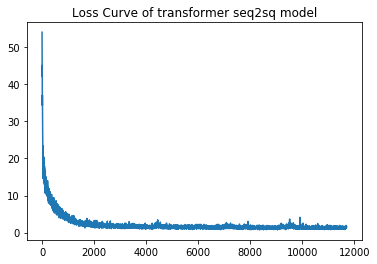

In [82]:
# save the loss curve figure in a file for the report
plt.plot(np.arange(len(loss_list)), loss_list)
plt.title('Loss Curve of transformer seq2sq model')
plt.savefig('./report_fig/loss_curve_transformer.png')

In [83]:
def comp_acc(pred, gt, valid_len, device):
    N, T_gt = gt.shape[:2]
    _, T_pr = pred.shape[:2]
    assert T_gt == T_pr, 'Prediction and target should have the same length.'
    len_mask = torch.arange(T_gt).expand(N, T_gt).to(device)
    len_mask = (len_mask < valid_len[:, None])

    pred_crr = (pred == gt).float() * len_mask.float() # filter out the 'bos' token
    pred_acc = pred_crr.sum(dim=-1) / (valid_len - 1).float() # minus the 'bos' token
    return pred_acc
  
net.eval()# for predicting, we need turn off the net.training by calling eval()
acc_list = []
for i, train_data in enumerate(train_iter):
    train_data = [ds.to(device) for ds in train_data]
    pred = net(*train_data)
    pred_acc = comp_acc(pred.detach().to(device), train_data[2].detach().to(device)[:, 1:], train_data[3].to(device), device)
    acc_list.append(pred_acc)
    if i < 5:# print 5 samples from 5 batches
        pred = pred[0].detach().to(device)
        pred_seq = []
        for t in range(MAX_LEN+1):
            pred_wd = vocab_fra.index2word[pred[t].item()] 
            if pred_wd != 'eos':
                pred_seq.append(pred_wd)

        print('pred:\t {}\n'.format(pred_seq))
        print('tgt:\t {}\n'.format([vocab_fra.index2word[t.item()] for t in train_data[2][0][1:].to(device)]))
    
print('Prediction Acc.: {:.4f}'.format(torch.cat(acc_list).mean()))


pred:	 ['fais', 'ce', 'que', 'je', 'dis', '.', 'unk', '.']

tgt:	 ['faites', 'ce', 'que', 'je', 'dis', '.', 'eos', 'pad', 'pad']

pred:	 ['je', 'ferai', 'ma', 'unk', '.', 'unk', '.']

tgt:	 ['je', 'ferai', 'mon', 'unk', '.', 'eos', 'pad', 'pad', 'pad']

pred:	 ['je', 'travaille', 'seul', '.', '.', '.']

tgt:	 ['je', 'travaille', 'seule', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

pred:	 ['il', 'unk', 'des', 'unk', '.', '.', '.']

tgt:	 ['il', 'a', 'unk', 'de', 'la', 'unk', '.', 'eos', 'pad']

pred:	 ['il', 'a', 'unk', '.', '.', '.']

tgt:	 ['il', 'se', 'unk', '.', 'eos', 'pad', 'pad', 'pad', 'pad']

Prediction Acc.: 0.6617
